In [16]:
import skimage.io as skio
import skimage
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import numpy as np
from bench_filter import Bench_Filter
from sklearn.model_selection import train_test_split
import random
import skimage.morphology as skm
from tools import *

In [2]:
from multiprocessing import cpu_count
cpus = cpu_count()
print(f'Number of CPU cores available : {cpus}')

Number of CPU cores available : 72


In [3]:
DATASET = ['Fluo-N2DL-HeLa','PhC-C2DH-U373']
idx = 0

IM_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TRAIN/*.tif'))
TG_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TRAIN/*.tif'))

In [4]:
X_train, y_train = load_img_tg(IM_PATH, TG_PATH)
len(X_train)

In [5]:
#To avoid memory storage error
#X_train = X_train[:int(len(X_train)/4)] #Divide by 4 for dataset 0 and 2 for dataset 1
#y_train = y_train[:int(len(y_train)/4)]

In [7]:
BF = Bench_Filter(n_estimators=20, cpus=cpus-1) #Leave 1 cpu to avoid computer crash
BF.add_identity()
BF.add_gaussian(np.sqrt(2)/2)
BF.add_gaussian(np.sqrt(2))
BF.add_gaussian(np.sqrt(2)*2) #Progression en sqrt(2)
BF.add_median(skm.disk(3))
BF.add_median()
BF.add_sobel()
BF.add_farid()
BF.add_prewitt()
BF.add_roberts()
BF.add_scharr()

In [8]:
BF.fit(X_train, y_train)

Applying filters to dataset: 138it [01:36,  1.43it/s]
[Parallel(n_jobs=71)]: Using backend ThreadingBackend with 71 concurrent workers.


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=71)]: Done  11 out of  20 | elapsed: 14.6min remaining: 12.0min
[Parallel(n_jobs=71)]: Done  20 out of  20 | elapsed: 15.6min finished


In [ ]:
IM_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TEST/*.tif'))
TG_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TEST/*.tif'))

X_test, y_test = load_img_tg(IM_TEST_PATH, TG_TEST_PATH)

In [9]:
y_pred = BF.predict(X_test)

Applying filters to dataset: 46it [00:32,  1.43it/s]
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   21.2s remaining:  2.0min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   23.5s remaining:   10.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   26.2s finished


Text(0, 0.5, 'Frequency')

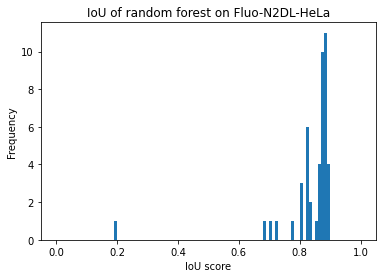

In [10]:
results = []
for i, pred in enumerate(y_test):
    results.append(jaccard_score(y_test[i],pred,average='micro'))
plt.hist(results,bins=100,range=(0,1))
plt.title(f'IoU of random forest on {DATASET[idx]}')
plt.xlabel('IoU score')
plt.ylabel('Frequency')
plt.savefig(f'output/rf_performance_dataset_{idx}.png')

Applying filters to dataset: 1it [00:00,  1.43it/s]
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.5s remaining:    2.9s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.8s finished


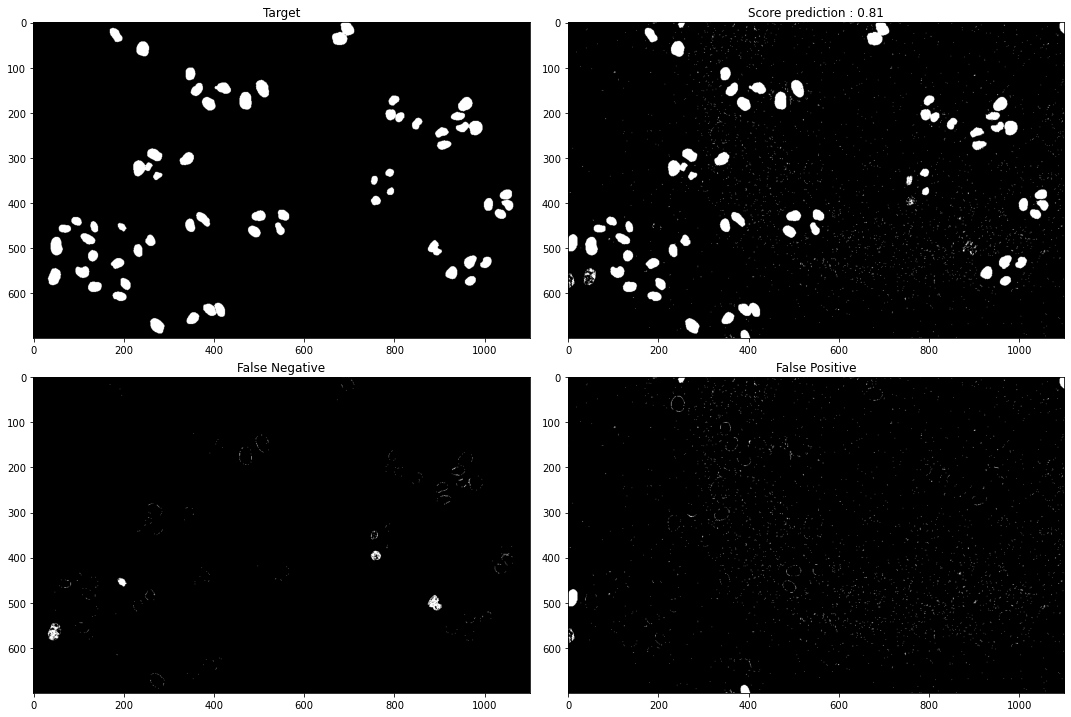

In [17]:
n_im = random.randrange(len(y_test))
target = y_test[n_im]
seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
score = jaccard_score(target,seg,average='micro')

fig = plot_pred_with_target(target,seg,score)
fig.savefig(f'output/inference_rf_dataset_{idx}.png')

Applying filters to dataset: 1it [00:00,  1.26it/s]
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.5s remaining:    2.7s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.7s finished


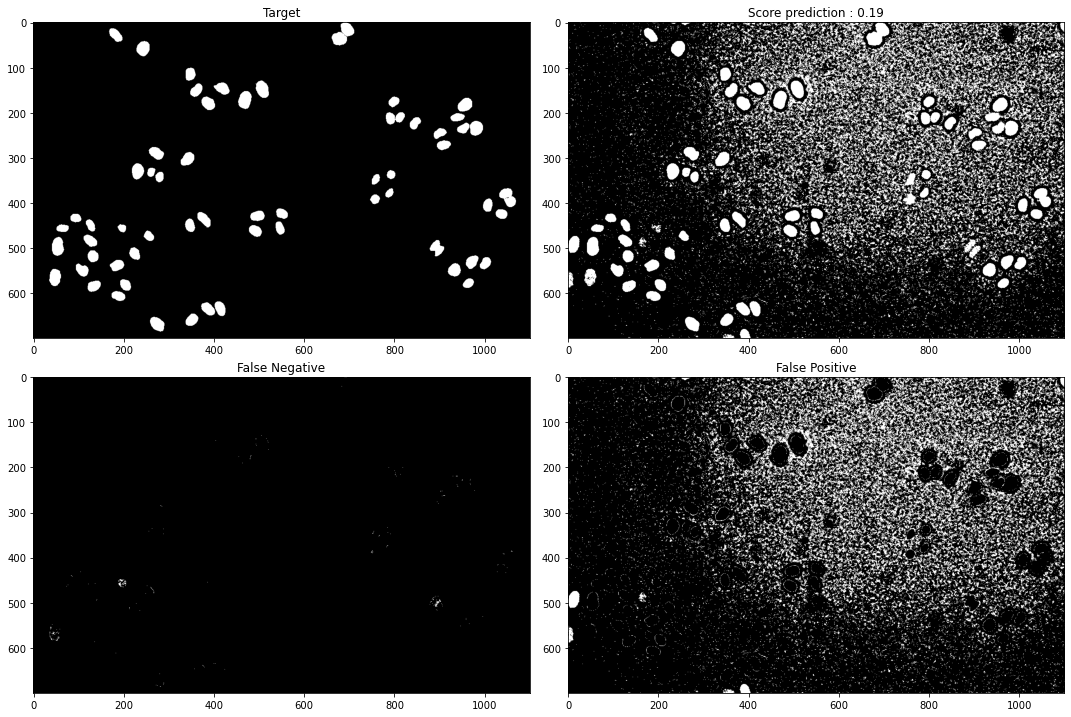

In [20]:
score = 1
n_im = 0
while score > 0.5 and n_im < len(y_test) :
    target = y_test[n_im]
    seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
    score = jaccard_score(target,seg,average='micro')
    
plot_pred_with_target(target,seg,score)
    